In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [5]:
skin_df = pd.read_csv('../data/hm10000_64_64_RGB.csv')
skin_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,label
0,191,152,194,191,153,195,192,149,192,194,151,188,193,149,182,193,150,181,195,154,185,195,156,189,203,164,196,206,166,203,209,165,201,211,166,206,209,165,206,203,...,202,167,183,199,159,175,189,141,148,184,131,136,180,128,136,179,127,141,176,129,149,175,127,145,179,136,157,182,146,164,185,154,180,186,156,184,182,152,173,2
1,24,13,23,24,14,28,37,24,46,61,44,70,90,66,97,111,83,118,127,98,129,144,112,141,161,131,159,169,138,165,171,135,159,173,135,156,178,138,164,178,...,176,132,147,163,121,129,143,96,96,129,89,90,111,76,74,92,60,64,69,46,56,44,27,43,30,16,34,27,14,30,26,15,29,27,15,28,24,13,25,2
2,185,129,140,192,136,151,198,142,156,198,140,154,199,141,158,199,141,159,205,147,162,205,151,167,208,154,171,207,147,161,204,146,153,207,154,161,209,156,163,210,...,199,156,175,190,147,171,194,154,183,197,152,172,175,129,140,160,117,132,163,127,141,161,128,140,161,128,144,155,122,139,152,120,138,144,113,123,115,81,84,2
3,24,11,19,36,19,30,64,38,50,91,60,71,111,71,87,130,91,106,150,114,129,160,116,124,167,110,111,168,100,101,176,110,116,184,131,144,191,141,152,191,...,154,124,138,143,111,126,129,100,111,102,74,80,94,73,86,74,47,61,52,32,45,33,17,25,28,13,19,27,13,17,27,13,16,25,12,16,24,9,14,2
4,138,94,117,158,113,138,178,133,161,191,143,172,202,150,173,212,160,185,216,162,191,222,175,209,227,183,219,229,183,216,232,188,221,234,193,222,234,191,218,235,...,221,169,202,226,167,201,226,164,197,224,176,203,224,178,206,222,181,206,213,170,191,200,155,177,187,148,164,164,128,140,140,106,118,108,77,92,67,40,55,2


In [7]:
X = skin_df.drop("label", axis=1).to_numpy()
label = skin_df["label"].values

In [35]:
X.shape , label.shape

((10015, 12288), (10015,))

### Normalization and Train,Test,Validation

In [9]:
X_mean = np.mean(X)
X_std = np.std(X)

X = (X - X_mean) / X_std
X_train_orig, X_test, y_train_orig, y_test = train_test_split(X, label, test_size=0.1,random_state=0)
X_train_orig.shape, X_test.shape, y_train_orig.shape, y_test.shape

((9013, 12288), (1002, 12288), (9013,), (1002,))

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train_orig, y_train_orig, test_size=0.2, random_state=1)
X_train.shape, X_val.shape, y_train.shape, y_val.shape


((7210, 12288), (1803, 12288), (7210,), (1803,))

### Making dataset ready to input to CNN

In [11]:
X_train = X_train.reshape(X_train.shape[0],*(64,64,3))
X_val = X_val.reshape(X_val.shape[0],*(64,64,3))
X_test = X_test.reshape(X_test.shape[0],*(64,64,3))

X_train.shape, X_val.shape, X_test.shape

((7210, 64, 64, 3), (1803, 64, 64, 3), (1002, 64, 64, 3))

In [12]:
y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [13]:
y_train.shape, y_val.shape, y_test.shape


((7210, 7), (1803, 7), (1002, 7))

# Cnn Model

In [17]:
import tensorflow as tf
print("Is GPU available:", tf.config.list_physical_devices('GPU'))


Is GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [49]:
img_input = layers.Input(shape=(64,64,3))

x = layers.Conv2D(16,3,activation='relu',padding='same')(img_input)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(32,3,activation='relu',padding='same')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(64,3,activation='relu',padding='same')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Conv2D(128,3,activation='relu',padding='same')(x)
x = layers.MaxPool2D(2)(x)

x = layers.Flatten()(x)

x = layers.Dense(512,activation='relu')(x)
x = layers.Dropout(0.2)(x)

x = layers.Dense(256,activation='relu')(x)
x = layers.Dropout(0.2)(x)

output = layers.Dense(7,activation='softmax')(x)

model = Model(inputs = img_input,outputs=output)

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [50]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │         1,799 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,279,655 (4.88 MB)

 Trainable params: 1,279,655 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

### Let's use Data Augmentation and Adaptive Learning rate to prevent Overfitting

In [51]:
train_datagen = ImageDataGenerator(rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest')

train_datagen.fit(X_train)
val_datagen = ImageDataGenerator()
val_datagen.fit(X_val)

In [52]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',patience=3,verbose=1,factor=0.5,min_lr=0.00001)

In [53]:
batch_size = 64
epochs = 30

tf.debugging.set_log_device_placement(True)

history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=val_datagen.flow(X_val, y_val),
    steps_per_epoch=X_train.shape[0] // batch_size,
    verbose=1,
    callbacks=[learning_rate_reduction]
)


Epoch 1/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.6374 - loss: 1.1223 - val_accuracy: 0.6811 - val_loss: 0.9032 - learning_rate: 0.0010
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6562 - loss: 0.9609 - val_accuracy: 0.6861 - val_loss: 0.9156 - learning_rate: 0.0010
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6743 - loss: 0.9041 - val_accuracy: 0.6705 - val_loss: 0.8899 - learning_rate: 0.0010
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5781 - loss: 0.9266 - val_accuracy: 0.6689 - val_loss: 0.8819 - learning_rate: 0.0010
Epoch 5/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6853 - loss: 0.8580 - val_accuracy: 0.6889 - val_loss: 0.8658 - learning_rate: 0.0010
Epoch 6/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7031 - loss: 0.8318 - val_accuracy: 0.6927 - val_loss: 0.8556 - learning_rate: 0.0010
Epoch 7/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.6938 - loss: 0.819

In [54]:
loss_test , acc_test = model.evaluate(X_test,y_test,verbose=1)
loss_val , acc_val = model.evaluate(X_val,y_val,verbose=1)

print(f"Validation accuracy : {acc_val}, Validation loss: {loss_val}")
print(f"Test accuracy : {acc_test}, Test loss: {loss_test}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7202 - loss: 0.8539
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7312 - loss: 0.8404
Validation accuracy : 0.7260122299194336, Validation loss: 0.8483824133872986
Test accuracy : 0.7405189871788025, Test loss: 0.7952511310577393


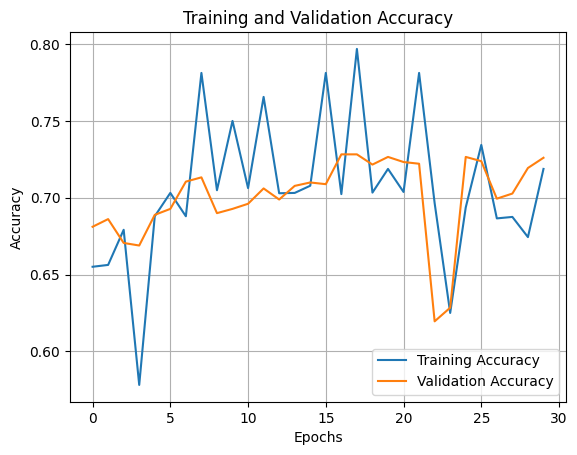

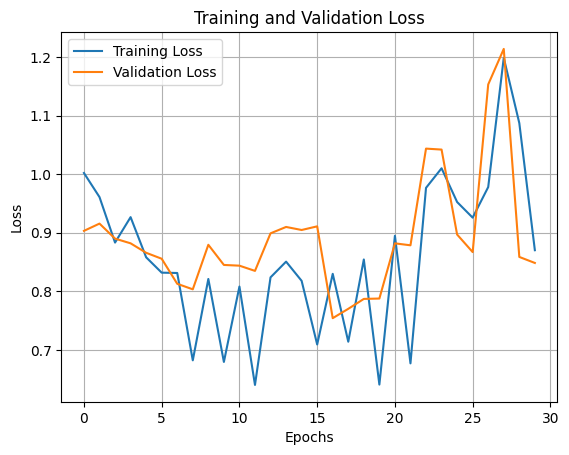

In [55]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

# Plot Accuracy
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title("Training and Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Plot Loss
plt.figure()
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()